# Tracking an unknown number of objects

While SVI can be used to learn components and assignments of a mixture model, pyro.contrib.tracking provides more efficient inference algorithms to estimate assignments. This notebook demonstrates how to use the `MarginalAssignmentPersistent` with EM.

In [1]:
from __future__ import absolute_import, division, print_function
import math
import os
import torch
from torch.distributions import constraints
from matplotlib import pyplot

import pyro
import pyro.distributions as dist
import pyro.poutine as poutine
from pyro.contrib.tracking.assignment import MarginalAssignmentPersistent
from pyro.contrib.tracking.hashing import LSH
from pyro.ops.newton import newton_step_2d
from pyro.infer import SVI, TraceEnum_ELBO
from pyro.optim import ClippedAdam, ASGD, SGD
from pyro.util import warn_if_nan

%matplotlib notebook
pyro.enable_validation(True)
smoke_test = ('CI' in os.environ)

Let's consider a model with deterministic dynamics, say sinusoids with known period but unknown phase and amplitude.

In [2]:
def get_dynamics(num_frames):
    time = torch.arange(num_frames,dtype=torch.float)*2*math.pi/num_frames
    return torch.stack([time.cos(), time.sin()], -1)

It's tricky to define a fully generative model, so instead we'll separate our data generation process `generate_data()` from a factor graph `model()` that will be used in inference.

In [3]:
def generate_data(args):
    # Object model.
    num_objects = int(round(args.expected_num_objects))  # Deterministic.
    states = dist.Normal(0., 1.).sample((num_objects, 2))

    # Detection model.
    emitted = dist.Bernoulli(args.emission_prob).sample((args.num_frames, num_objects))
    num_spurious = dist.Poisson(args.expected_num_spurious).sample((args.num_frames,))
    max_num_detections = int((num_spurious + emitted.sum(-1)).max())
    observations = torch.zeros(args.num_frames, max_num_detections, 1+1) # position+confidence
    positions = get_dynamics(args.num_frames).mm(states.t())
    noisy_positions = dist.Normal(positions, args.emission_noise_scale).sample()
    for t in range(args.num_frames):
        j = 0
        for i, e in enumerate(emitted[t]):
            if e:
                observations[t, j, 0] = noisy_positions[t, i]
                observations[t, j, 1] = 1
                j += 1
        n = int(num_spurious[t])
        if n:
            observations[t, j:j+n, 0] = dist.Normal(0., 1.).sample((n,))
            observations[t, j:j+n, 1] = 1

    return states, positions, observations

In [4]:
@poutine.broadcast
def model(args, observations):
    with pyro.iarange("objects", args.max_num_objects):
        exists = pyro.sample("exists",
                             dist.Bernoulli(args.expected_num_objects / args.max_num_objects))
        with poutine.scale(scale=exists):
            states = pyro.sample("states", dist.Normal(0., 1.).expand([2]).independent(1))
            positions = get_dynamics(args.num_frames).mm(states.t())
    with pyro.iarange("detections", observations.shape[1]):
        with pyro.iarange("time", args.num_frames):
            # The combinatorial part of the log prob is approximated to allow independence.
            is_observed = (observations[..., -1] > 0)
            with poutine.scale(scale=is_observed.float()):
                assign = pyro.sample("assign",
                                     dist.Categorical(torch.ones(args.max_num_objects + 1)))
            is_spurious = (assign == args.max_num_objects)
            is_real = is_observed & ~is_spurious
            num_observed = is_observed.float().sum(-1, True)
            # TODO Make these Bernoulli probs more plausible.
            pyro.sample("is_real",
                        dist.Bernoulli(args.expected_num_objects / observations.shape[1]),
                        obs=is_real.float())
            pyro.sample("is_spurious",
                        dist.Bernoulli(args.expected_num_spurious / observations.shape[1]),
                        obs=is_spurious.float())

            # The remaining continuous part is exact.
            observed_positions = observations[..., 0]
            with poutine.scale(scale=is_real.float()):
                bogus_position = positions.new_zeros(args.num_frames, 1)
                augmented_positions = torch.cat([positions, bogus_position], -1)
                predicted_positions = augmented_positions[:, assign]
                pyro.sample("real_observations",
                            dist.Normal(predicted_positions, args.emission_noise_scale),
                            obs=observed_positions)
            with poutine.scale(scale=is_spurious.float()):
                pyro.sample("spurious_observations", dist.Normal(0., 1.),
                            obs=observed_positions)

In [5]:
def compute_assign_logits(positions, observations, args):
    log_likelihood = detection_log_likelihood(positions, observations, args)
    assign_logits = log_likelihood[...,:-1] - log_likelihood[...,-1:]
    assign_logits[log_likelihood[..., 0]== -float('inf')] = -float('inf')
    return assign_logits

def detection_log_likelihood(positions, observations, args):
    real_dist = dist.Normal(positions.unsqueeze(-2), args.emission_noise_scale)
    spurious_dist = dist.Normal(0., 1.)
    is_observed = (observations[..., -1] > 0)
    observed_positions = observations[..., 0].unsqueeze(-1)
    a=(real_dist.log_prob(observed_positions) +
                 math.log(args.expected_num_objects * args.emission_prob))
    b= (spurious_dist.log_prob(observed_positions) +
                                 math.log(args.expected_num_spurious))
    assign_logits = torch.cat((a,b), dim=-1)
    assign_logits[~is_observed] = -float('inf')
    return assign_logits

## Merging

This implementation of merging function averages `states_loc`, and sums `exist_dist_probs` and `assign_dist_probs`.

In [6]:
import heapq
def merge_objects(assignment, states_loc, threshold):
    exist_dist_probs = assignment.exists_dist.probs
    spurious_prob = assignment.assign_dist.probs[...,-1:]
    assign_dist_probs = assignment.assign_dist.probs[...,:-1].permute(2,0,1)
    distance2 = (states_loc.unsqueeze(-2) -
                  states_loc.unsqueeze(-3)).pow(2).sum(-1)
    ind = ((distance2 < threshold**2) & 
           (assignment.exists_dist.probs.unsqueeze(0) > 1.5e-7) &
           (assignment.exists_dist.probs.unsqueeze(-1) > 1.5e-7) 
          ).nonzero()
    if len(ind) == 0:
        return assignment, states_loc
    ind = ind[ind[:, 0] < ind[:, 1]]


    # setup data structures to cheaply search for nearest pairs
    priority_queue = []
    for i, j in ind:
        heapq.heappush(priority_queue, (distance2[i, j], i.item(), j.item()))
    lsh = LSH(1)
    for i, state in enumerate(states_loc):
        lsh.add(i, state)
    next_id = len(states_loc)
    states_loc = dict(enumerate(states_loc))
    exist_dist_probs = dict(enumerate(exist_dist_probs))
    assign_dist_probs = dict(enumerate(assign_dist_probs))
    while priority_queue:
        d1, i, j = heapq.heappop(priority_queue)
        if i not in states_loc or j not in states_loc:
            continue
        k = next_id
        next_id += 1
        # Merging
        states_loc[k] = (states_loc.pop(i) + states_loc.pop(j)) / 2
        merge_fn = lambda a,b: (a.pow(2) + b.pow(2)) / (a + b) #contra-mean
        #merge_fn = lambda a,b: 2 / (1 / a + 1 / b) # harmonic mean
        #merge_fn = lambda a,b: a + b # sum
        exist_dist_probs[k] = merge_fn(exist_dist_probs.pop(i),exist_dist_probs.pop(j))
        exist_dist_probs[k].clamp_(min=0.0, max=1.0)
        assign_dist_probs[k] = (assign_dist_probs.pop(i) + assign_dist_probs.pop(j))
        assign_dist_probs[k].clamp_(min=0.0, max=1.0)
        lsh.remove(i)
        lsh.remove(j)
        lsh.add(k, states_loc[k])
        for i in lsh.nearby(k):
            if i == k:
                continue
            d2 = (states_loc[i] - states_loc[k]).pow(2).sum()
            if d2 < threshold:
                heapq.heappush(priority_queue, (d2, i, k))

    ids = sorted(states_loc.keys())
    states_loc = torch.stack([states_loc[i] for i in ids])
    states_loc = torch.cat([states_loc, 
                            torch.zeros((assignment.num_objects-states_loc.shape[0],
                                         states_loc.shape[1]),
                                         dtype=states_loc.dtype,
                                         layout=states_loc.layout,
                                         device=states_loc.device)
                               ])
    
    exist_dist_probs = torch.stack([exist_dist_probs[i] for i in ids])
    exist_dist_probs = torch.cat([exist_dist_probs, 
                                   torch.zeros((assignment.num_objects-exist_dist_probs.shape[0]),
                                                 dtype=exist_dist_probs.dtype,
                                                 layout=exist_dist_probs.layout,
                                                 device=exist_dist_probs.device)
                                   ],dim=-1)
    assign_dist_probs = torch.stack([assign_dist_probs[i] for i in ids]).permute(1,2,0)
    assign_dist_probs = torch.cat([assign_dist_probs, 
                                   torch.zeros((assign_dist_probs.shape[0],
                                                 assign_dist_probs.shape[1],
                                                 assignment.num_objects-assign_dist_probs.shape[2]),
                                                 dtype=assign_dist_probs.dtype,
                                                 layout=assign_dist_probs.layout,
                                                 device=assign_dist_probs.device),
                                   spurious_prob,
                                   ],dim=-1)
    assignment.exists_dist = dist.Bernoulli(probs=exist_dist_probs)
    assert (exist_dist_probs == assignment.exists_dist.probs).all()
    assignment.assign_dist = dist.Categorical(probs=assign_dist_probs)
    
    return assignment, states_loc 

## Guide
This guide uses EM.

In [7]:
@poutine.broadcast
def guide(args, observations):
    emission_noise_scale = pyro.param("emission_noise_scale", torch.tensor(0.12345),
                                      constraint=constraints.positive)
    # Initialize states randomly from the prior.
    states_loc = pyro.param("states_loc", lambda: torch.randn(args.max_num_objects, 2))
    is_observed = (observations[..., -1] > 0) 
    
    for em_iter in range(args.em_iters):
        states_loc = states_loc.detach()
        states_loc.requires_grad = True
        positions = get_dynamics(args.num_frames).mm(states_loc.t())
        
        # E-step: compute soft assignments
        with torch.no_grad():
            assign_logits = compute_assign_logits(positions, observations, args)
            exists_logits = torch.empty(args.max_num_objects).fill_(
                math.log(args.expected_num_objects / args.max_num_objects))
            assignment = MarginalAssignmentPersistent(exists_logits, assign_logits,
                                              args.bp_iters, bp_momentum=args.bp_momentum)
            p_exists = assignment.exists_dist.probs
            p_assign = assignment.assign_dist.probs
        
        log_likelihood = detection_log_likelihood(positions,observations, args)
        loss = -(log_likelihood * p_assign).sum()
        # M-step:
        states_loc, states_cov = newton_step_2d(loss, states_loc, emission_noise_scale)
        if args.merge_threshold >= 0.0:
            assignment, states_loc = merge_objects(assignment, states_loc, args.merge_threshold)
        warn_if_nan(states_loc, 'states_loc')
        warn_if_nan(states_cov, 'states_cov')
    
    with pyro.iarange("objects", args.max_num_objects):
        exists = pyro.sample("exists", assignment.exists_dist, infer={"enumerate": "parallel"})
        with poutine.scale(scale=exists):
            pyro.sample("states", dist.Delta(states_loc).independent(1))
    with pyro.iarange("detections", observations.shape[1]):
        with poutine.scale(scale=is_observed.float()):
            with pyro.iarange("time", args.num_frames):
                pyro.sample("assign", assignment.assign_dist, infer={"enumerate": "parallel"})

    return assignment, states_loc

## Plotting

We'll use these plotting helpers before and after training.

In [8]:
def plot_solution(assignment, states_loc, message=''):
    positions = get_dynamics(args.num_frames).mm(states_loc.t())
    fig = pyplot.figure(figsize=(12,6))
    fig.patch.set_color('white')
    pyplot.plot(true_positions.numpy(), 'k--')
    is_observed = (observations[..., -1] > 0)
    pos = observations[..., 0]
    time = torch.arange(args.num_frames).unsqueeze(-1).expand_as(pos)
    pyplot.scatter(time[is_observed].view(-1).numpy(),
                   pos[is_observed].view(-1).numpy(), color='k', marker='+',
                   label='observation')
    for i in range(args.max_num_objects):
        p_exists = assignment.exists_dist.probs[i].item()
        position = positions[:, i].detach().numpy()
        pyplot.plot(position, alpha=p_exists, color='C0')
    if args.expected_num_objects == 1:
        p_exists = assignment.exists_dist.probs
        mean = (p_exists * positions).sum(-1) / p_exists.sum(-1)
        pyplot.plot(mean.detach().numpy(), 'r--', alpha=0.5, label='mean')
    pyplot.title('Truth, observations, and {:0.1f} predicted tracks {}'.format(
                 assignment.exists_dist.probs.sum().item(), message))
    pyplot.plot([], 'k--', label='truth')
    pyplot.plot([], color='C0', label='prediction')
    pyplot.legend(loc='best')
    pyplot.xlabel('time step')
    pyplot.ylabel('position')
    pyplot.tight_layout()

def plot_exists_histogram(p_exists):
    p_exists = p_exists.detach().numpy()
    pyplot.figure(figsize=(6,4)).patch.set_color('white')
    pyplot.plot(sorted(p_exists))
    pyplot.ylim(0, None)
    pyplot.xlim(0, len(p_exists))
    pyplot.ylabel('p_exists')
    pyplot.xlabel('rank')
    pyplot.title('Prob(exists) of {} potential objects, total = {:0.2f}'.format(
        len(p_exists), p_exists.sum()))
    pyplot.tight_layout()

## Generate data

We'll define a global config object to make it easy to port code to `argparse`.

In [9]:
args = type('Args', (object,), {})  # A fake ArgumentParser.parse_args() result.

args.num_frames = 40
args.max_num_objects = 100
args.expected_num_objects = 2.
args.expected_num_spurious = 0.1  # If this is too small, BP will be unstable.
args.emission_prob = 0.9          # If this is too large, BP will be unstable.
args.emission_noise_scale = 0.1   # If this is too small, SVI will see flat gradients.
args.bp_iters = 50
args.bp_momentum =0.5
args.svi_iters = 201
args.em_iters = 10
args.merge_threshold = 0.2
assert args.max_num_objects >= args.expected_num_objects

In [10]:
pyro.set_rng_seed(0)
true_states, true_positions, observations = generate_data(args)
true_num_objects = len(true_states)
max_num_detections = observations.shape[1]
assert true_states.shape == (true_num_objects, 2)
assert true_positions.shape == (args.num_frames, true_num_objects)
assert observations.shape == (args.num_frames, max_num_detections, 1+1)
print("generated {:d} detections from {:d} objects".format(
    (observations[..., -1] > 0).long().sum(), true_num_objects))

generated 80 detections from 2 objects


## Training via EM

10 iterations of EM without merging:

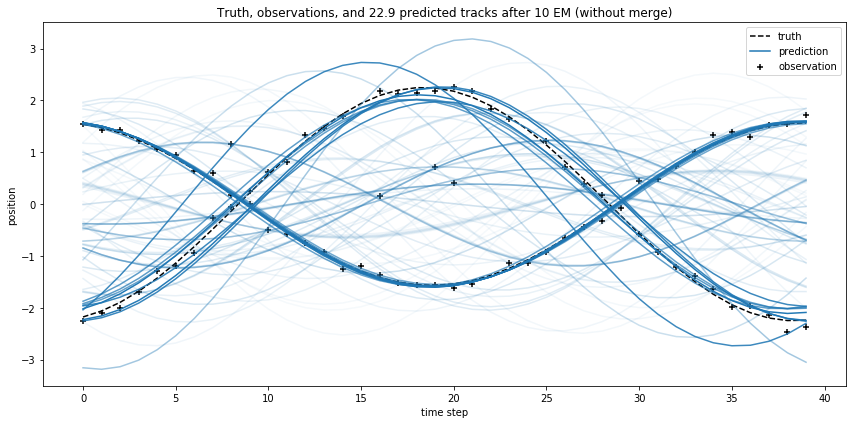

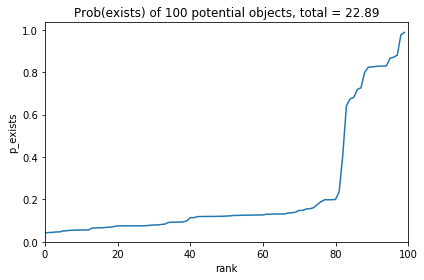

In [11]:
pyro.set_rng_seed(1)  # Use a different seed from data generation
old_merge_threshold = args.merge_threshold
args.merge_threshold = -1
pyro.clear_param_store()

assignment, states_loc = guide(args, observations)
plot_solution(assignment, states_loc, 'after 10 EM (without merge)')
plot_exists_histogram(assignment.exists_dist.probs)
args.merge_threshold = old_merge_threshold

With merging:

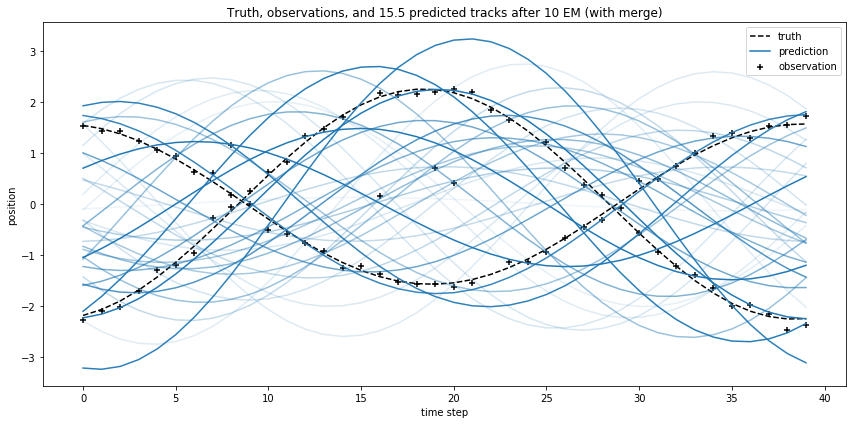

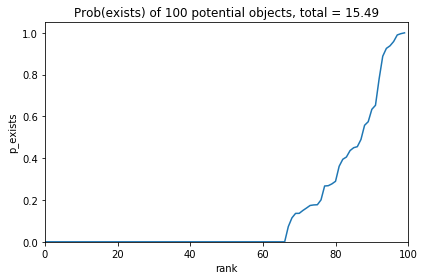

In [12]:
pyro.set_rng_seed(1)  # Use a different seed from data generation
pyro.clear_param_store()

assignment, states_loc = guide(args, observations)
plot_solution(assignment, states_loc, 'after 10 EM (with merge)')
plot_exists_histogram(assignment.exists_dist.probs)

## Training SVI+EM

Training within SVI

epoch   0 loss = 768929.8125, emission_noise_scale = 0.111702203751
epoch   1 loss = 759970.8125, emission_noise_scale = 0.119272701442
epoch   2 loss = 770454.0, emission_noise_scale = 0.129333332181
epoch   3 loss = 760928.1875, emission_noise_scale = 0.141188070178
epoch   4 loss = 758312.5, emission_noise_scale = 0.146506652236
epoch   5 loss = 755166.625, emission_noise_scale = 0.147266387939
epoch   6 loss = 755406.4375, emission_noise_scale = 0.14484937489
epoch   7 loss = 754640.5, emission_noise_scale = 0.140252396464
epoch   8 loss = 758457.4375, emission_noise_scale = 0.138928472996
epoch   9 loss = 758706.75, emission_noise_scale = 0.140070512891


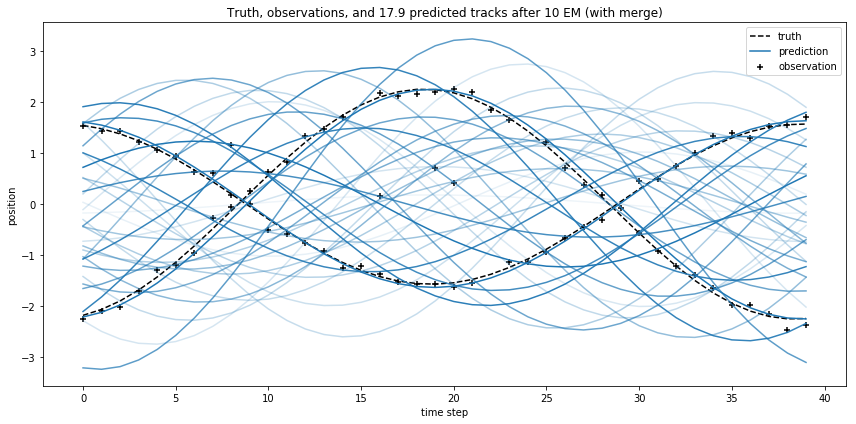

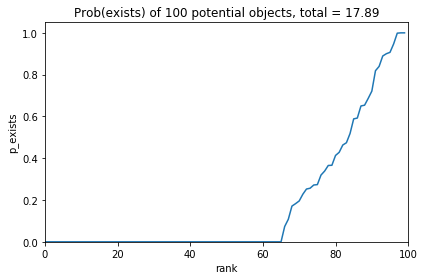

In [13]:
pyro.set_rng_seed(1)  # Use a different seed from data generation
pyro.clear_param_store()

elbo = TraceEnum_ELBO(max_iarange_nesting=2)
optim = ClippedAdam({'lr': 0.1})
svi = SVI(model, guide, optim, elbo)
losses = []
for epoch in range(10):
    loss = svi.step(args, observations)
    losses.append(loss)
    print('epoch {: >3d} loss = {}, emission_noise_scale = {}'.format(
        epoch, loss, pyro.param("emission_noise_scale").item()))

assignment, states_loc = guide(args, observations)
plot_solution(assignment, states_loc, 'after 10 EM (with merge)')
plot_exists_histogram(assignment.exists_dist.probs)